[Group 1 Galaxies](#1)
[Group 2 Galaxies](#2)
[Group 3 Galaxies](#3)
[Group 4 Galaxies](#4)
[Group 5 Galaxies](#5)
[Group 6 Galaxies](#6)

### This code provides the SVR prdictions and a plot of true vs predicted values of galaxy sizes' independent datasets divided by 6 galaxy morphologies and using only the 10 most important features of each bin as input: 

### Groups 1, 2, 3, 4, 5 and 6 (ellipticals)

In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor


In [2]:
import target_predicting_ML_functions_and_feature_ranking as functions

In [3]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel("R2 score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

#### <font color='violet'> ML modelling with 33 galaxy and halo features; df from v5 used here


#### Read the normalized 31-feature dataset (see explanations in related doc 'TNG-SAM 33-feature analysis')

In [4]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

#### Add the column 'BulgeMstar_ratio' defined as Bulge mass / Stellar mass, to be used as a proxy for galaxy morphology

In [5]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']


In [6]:
df_normalized_31.shape

(35390, 33)

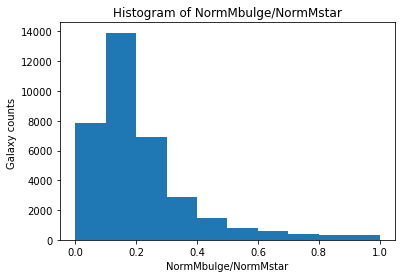

In [7]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Histogram of NormMbulge/NormMstar')
plt.xlabel('NormMbulge/NormMstar')
plt.ylabel('Galaxy counts ')
# plt.savefig('Histogram of GalpropNormMbulgebyNormMstar.jpg', dpi=500)

plt.show()

#### Define the 6 morphology groups by increasing Mbulge/Mstar ratio

In [8]:
# 7,865 galaxies in df_1
df_1 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.10] 

# 13,921 galaxies in df_2
df_2 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.10) & (df_normalized_31.BulgeMstar_ratio <= 0.20)] 

# 6,880 galaxies in df_3
df_3 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.20) & (df_normalized_31.BulgeMstar_ratio <= 0.30)] 

# 2,858 galaxies in df_4
df_4 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.30) & (df_normalized_31.BulgeMstar_ratio <= 0.40)] 

# 1,444 galaxies in df_5
df_5 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.40) & (df_normalized_31.BulgeMstar_ratio <= 0.50)] 

# 2,422 galaxies in df_5
df_6 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']>0.50] 


## <font color='purple'> <a id =0> </a> <br> All morphologies

In [9]:
X_all = df_normalized_31.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_all = df_normalized_31.loc[:,'GalpropNormHalfRadius']

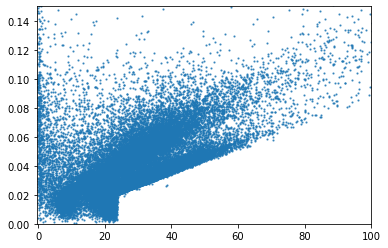

In [10]:
plt.scatter(y_all, X_all.loc[:, 'HalopropSpin'], alpha = 0.7, marker = '.', s = 6)
plt.xlim(-0.5, 100)
plt.ylim(0, 0.15)
plt.show()

In [12]:
# this code takes ~ 50min to run it on the complete dataset with ~35,000 galaxies 
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':[0.00001,'scale', 0.01, 0.1, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000, 10000, 100000], \
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = -1, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Complete Dataset: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 49 candidates, totalling 147 fits


KeyboardInterrupt: 

In [76]:
best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [77]:
y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

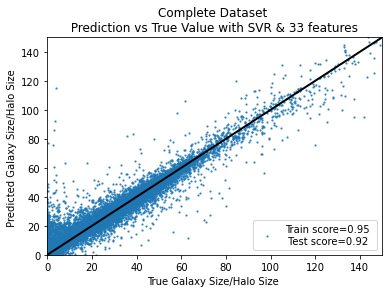

In [81]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_all, 2),round(scores_SVR_all.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_all, y_pred_SVR_all, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Complete Dataset \n Prediction vs True Value with SVR & 33 features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
plt.savefig('Complete_Dataset_Prediction_vs_True_SVR_halofeat.jpeg', dpi=500)

plt.show()

Elapsed time to run SVR Learning Curves on the complete dataset: 2714.244 seconds


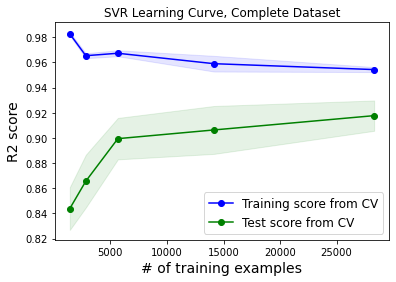

In [84]:
# this code takes ~2.5min to run on the whole dataset with ~35,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR Learning Curve, Complete Dataset w Spin & C_nfw features only', X_all, y_all, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
plt.savefig('LC_SVR_Complete_Dataset_halofeat.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

In [82]:
# lc_all.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)

<Figure size 432x288 with 0 Axes>


## <font color='purple'> <a id =1> </a> <br> Group 1 Galaxies: B/Mstar <= 0.1

In [13]:
X_imp_1 = df_1.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_1 = df_1.loc[:,'GalpropNormHalfRadius']

#### Using the SVR Gridsearch best params from the whole dataset trial in notebook v10 (where I waited 10 days to get the  125 fits (87%) out of 144 with the best parameters are: C=1000, gamma=scale, kernel=rbf (gaussian), train score=0.954, test score=0.926 on the whole ~35,000 galaxies dataset)

In [15]:
# this code takes ~ 105.96 to run with 2 features when the dataset is Group 1 galaxies with ~7,800 entries
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 0.1, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              }

# Using best parameters for 10 features input:
# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':[0.1], 
#               'svr__C':[1000.0], \
#               }

model_1 = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_1.fit(X_imp_1, y_1)

print('Best params, best score:', "{:.4f}".format(model_1.best_score_), \
      model_1.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Group 1: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params, best score: 0.7084 {'svr__C': 100.0, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Group 1: 105.956 seconds


In [16]:
best_SVR_1=model_1.best_estimator_

best_SVR_trainscore_1=model_1.cv_results_['mean_train_score'][model_1.best_index_]

scores_SVR_1 = cross_val_score(best_SVR_1, X_imp_1, y_1, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [17]:
scores_SVR_1.mean()

0.7072340794095748

In [18]:
y_pred_SVR_1 = cross_val_predict(best_SVR_1, X_imp_1, y_1, cv = KFold(n_splits=5, shuffle=True, random_state=10))

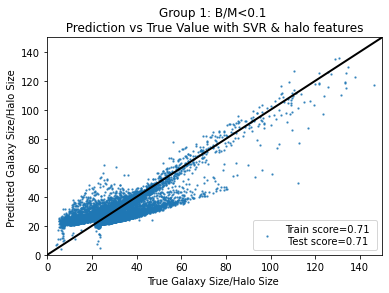

In [19]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_1, 2),round(scores_SVR_1.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_1, y_pred_SVR_1, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Group 1: B/M<0.1 \n Prediction vs True Value with SVR & halo features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Group1_Prediction_vs_True_SVR_halo_features_after_hyper_opt.jpeg', dpi=500)

plt.show()

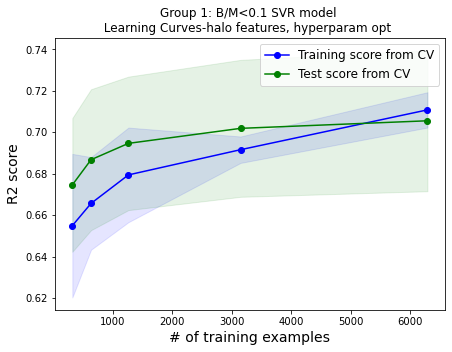

In [20]:
lc_1 = plot_learning_curve(best_SVR_1, 'Group 1: B/M<0.1 SVR model \n Learning Curves-halo features, hyperparam opt  ', X_imp_1, y_1, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# lc_1.savefig('LC_SVR_Group1_after_hyper_opt_w_halo_feat.jpeg', dpi=500)

--------------------

## <font color='purple'> <a id =2> </a> <br>Group 2 Galaxies: 0.1 < B/Mstar <=0.2

In [21]:
X_imp_2 = df_2.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_2 = df_2.loc[:,'GalpropNormHalfRadius']

# X_2_sample = df_2_sample.drop(columns=['GalpropNormHalfRadius', 'BulgeMstar_ratio'])


# y_2_sample = df_2_sample.loc[:,'GalpropNormHalfRadius']

In [22]:
# this code takes ~ 5641.176 seconds (2hrs) to run with a random sample of 7,000 galaxies in Group2 and halo features.
# The complete dataset of Group 2 is ~14,000 galaxies.
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 0.1, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              }

# Using best parameters for 10 features input:
# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':[0.01], 
#               'svr__C':[1000.0], \
#               }

model_2 = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_2.fit(X_imp_2 , y_2)  # fit the model defined in Group 1 into Group 2 data

print('Best params, best score:', "{:.4f}".format(model_2.best_score_), \
      model_2.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Group 2: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.7421 {'svr__C': 1000, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Group 2: 5641.176 seconds


In [23]:
best_SVR_2=model_2.best_estimator_

best_SVR_trainscore_2=model_2.cv_results_['mean_train_score'][model_2.best_index_]

scores_SVR_2 = cross_val_score(best_SVR_2, X_imp_2, y_2, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [24]:
scores_SVR_2.mean()

0.7423039940282455

In [25]:
y_pred_SVR_2 = cross_val_predict(best_SVR_2, X_imp_2, y_2, cv = KFold(n_splits=5, shuffle=True, random_state=10))

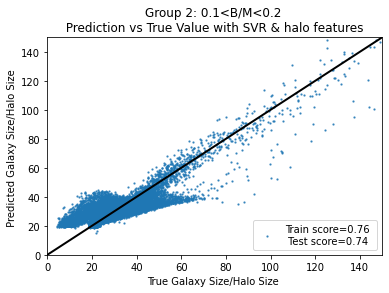

In [26]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_2, 2),round(scores_SVR_2.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_2, y_pred_SVR_2, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Group 2: 0.1<B/M<0.2 \n Prediction vs True Value with SVR & halo features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
# plt.savefig('Group2_Prediction_vs_True_SVR_halo_features_after_hyper_opt.jpeg', dpi=500)

plt.show()

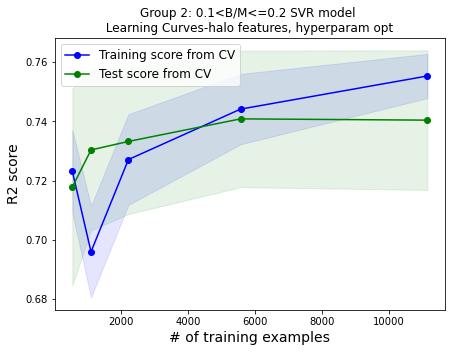

In [30]:
lc_2 = plot_learning_curve(best_SVR_2, 'Group 2: 0.1<B/M<=0.2 SVR model \n Learning Curves-halo features, hyperparam opt ', X_imp_2, y_2, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# lc_2.savefig('LC_SVR_Group2_after_hyper_opt_w_halo_feat.jpeg', dpi=500)

## <font color='purple'> <a id =3> </a> <br>Group 3 Galaxies: 0.2< B/Mstar <=0.3

In [31]:
X_imp_3 = df_3.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_3 = df_3.loc[:,'GalpropNormHalfRadius']

In [32]:
# this code takes ~70 min (all the features) to run when the dataset is Group 3 galaxies with ~7,000 entries
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':[0.00001,'scale', 0.01, 0.1, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000, 10000, 100000], \
              }

# Using best parameters for 10 features input:
# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':[0.01], 
#               'svr__C':[1000.0], \
#               }

model_3 = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_3.fit(X_imp_3, y_3)  # fit the model defined in Group 1 into Group 2 data

print('Best params, best score:', "{:.4f}".format(model_3.best_score_), \
      model_3.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Group 3: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 49 candidates, totalling 147 fits
Best params, best score: 0.7498 {'svr__C': 1000, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Group 3: 4081.720 seconds


In [33]:
best_SVR_3=model_3.best_estimator_

best_SVR_trainscore_3=model_3.cv_results_['mean_train_score'][model_3.best_index_]

scores_SVR_3 = cross_val_score(best_SVR_3, X_imp_3, y_3, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [34]:
scores_SVR_3.mean()

0.7514172789784549

In [35]:
y_pred_SVR_3 = cross_val_predict(best_SVR_3, X_imp_3, y_3, cv = KFold(n_splits=5, shuffle=True, random_state=10))

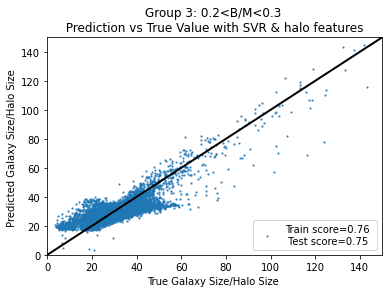

In [36]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_3, 2),round(scores_SVR_3.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_3, y_pred_SVR_3, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Group 3: 0.2<B/M<0.3 \n Prediction vs True Value with SVR & halo features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
plt.savefig('Group3_Prediction_vs_True_SVR_halo_features_after_hyper_opt.jpeg', dpi=500)

plt.show()

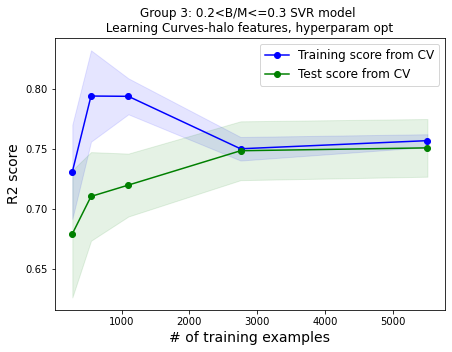

In [37]:
lc_3 = plot_learning_curve(best_SVR_3, 'Group 3: 0.2<B/M<=0.3 SVR model \n Learning Curves-halo features, hyperparam opt ', X_imp_3, y_3, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
lc_3.savefig('LC_SVR_Group3_after_hyper_opt_w_halo_feat.jpeg', dpi=500)

## <font color='purple'> <a id =4> </a> <br>Group 4: 0.3< B/Mstar <=0.4

In [38]:
X_imp_4 = df_4.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_4 = df_4.loc[:,'GalpropNormHalfRadius']

In [39]:
# this code takes ~4min (240 seconds) to run when the dataset is Group 4 galaxies with ~3,000 entries
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':[0.00001,'scale', 0.01, 0.1, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000, 10000, 100000], \
              }

# Using best parameters for 10 features input:
# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':[0.01], 
#               'svr__C':[1000.0], \
#               }

model_4 = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_4.fit(X_imp_4, y_4)  # fit the model defined in Group 1 into Group 4 data

print('Best params, best score:', "{:.4f}".format(model_4.best_score_), \
      model_4.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Group 4: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 49 candidates, totalling 147 fits
Best params, best score: 0.6734 {'svr__C': 1000, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Group 4: 476.674 seconds


In [40]:
best_SVR_4=model_4.best_estimator_

best_SVR_trainscore_4=model_4.cv_results_['mean_train_score'][model_4.best_index_]

scores_SVR_4 = cross_val_score(best_SVR_4, X_imp_4, y_4, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [41]:
scores_SVR_4.mean()

0.6674106077351015

In [42]:
y_pred_SVR_4 = cross_val_predict(best_SVR_4, X_imp_4, y_4, cv = KFold(n_splits=5, shuffle=True, random_state=10))

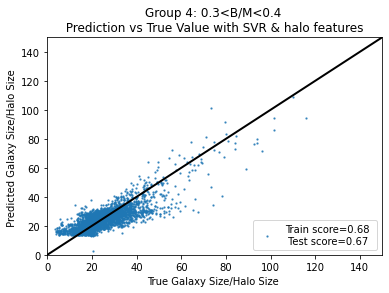

In [43]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_4, 2),round(scores_SVR_4.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_4, y_pred_SVR_4, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Group 4: 0.3<B/M<0.4 \n Prediction vs True Value with SVR & halo features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
plt.savefig('Group4_Prediction_vs_True_SVR_halo_features.jpeg', dpi=500)

plt.show()

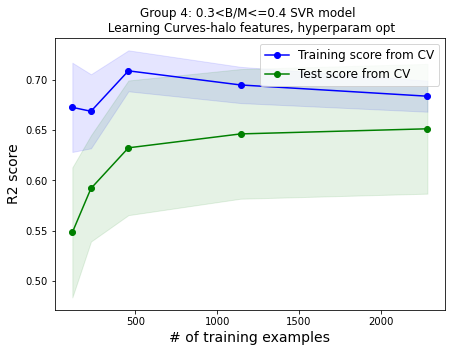

In [44]:
lc_4 = plot_learning_curve(best_SVR_4, 'Group 4: 0.3<B/M<=0.4 SVR model \n Learning Curves-halo features, hyperparam opt', X_imp_4, y_4, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
lc_4.savefig('LC_SVR_Group4_after_hyper_opt_w_halo_feat.jpeg', dpi=500)

## <font color='purple'> <a id =5> </a> <br>Group 5: 0.4< B/Mstar <=0.5

In [45]:
X_imp_5 = df_5.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_5 = df_5.loc[:,'GalpropNormHalfRadius']

In [46]:
# this code takes ~ 76.5 seconds (with X_imp) to run when the dataset is Group 5 galaxies with ~1,400 entries
start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':[0.00001,'scale', 0.01, 0.1, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000, 10000, 100000], \
              }

# Using best parameters for 10 features input:
# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':['scale'], 
#               'svr__C':[100.0], \
#               }
model_5 = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_5.fit(X_imp_5, y_5)  # fit the model defined in Group 1 into Group 2 data

print('Best params, best score:', "{:.4f}".format(model_5.best_score_), \
      model_5.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on Group 5: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 49 candidates, totalling 147 fits
Best params, best score: 0.1496 {'svr__C': 10.0, 'svr__gamma': 0.1, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on Group 5: 121.210 seconds


In [47]:
best_SVR_5=model_5.best_estimator_

best_SVR_trainscore_5=model_5.cv_results_['mean_train_score'][model_5.best_index_]

scores_SVR_5 = cross_val_score(best_SVR_5, X_imp_5, y_5, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

In [48]:
scores_SVR_5.mean()

0.1409287804644545

In [49]:
y_pred_SVR_5 = cross_val_predict(best_SVR_5, X_imp_5, y_5, cv = KFold(n_splits=5, shuffle=True, random_state=10))

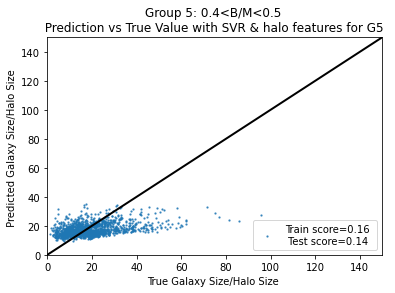

In [50]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_5, 2),round(scores_SVR_5.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_5, y_pred_SVR_5, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Group 5: 0.4<B/M<0.5 \n Prediction vs True Value with SVR & halo features for G5 ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
plt.savefig('Group5_Prediction_vs_True_SVR_halo_features.jpeg', dpi=500)

plt.show()

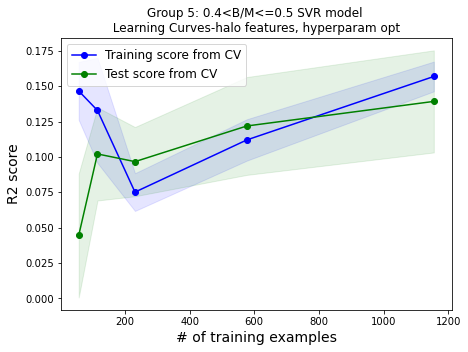

In [51]:
lc_5 = plot_learning_curve(best_SVR_5, 'Group 5: 0.4<B/M<=0.5 SVR model \n Learning Curves-halo features, hyperparam opt ', X_imp_5, y_5, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
lc_5.savefig('LC_SVR_Group5_after_hyper_opt_w_halo_feat.jpeg', dpi=500)


## <font color='purple'> <a id =6> </a> <br> Group 6 (Elliptical) Galaxies:  B/Mstar > 0.5

In [52]:
X_imp_6 = df_6.loc[:, ['HalopropSpin', 'HalopropC_nfw']]


y_6 = df_6.loc[:,'GalpropNormHalfRadius']

#### Choose the 10 most important features for ellipticals, as determined by RF, and use only these 10 features when searching for optimal SVR hyperparameters.

In [53]:
# Note: It takes about ~7 minutes (419.925 seconds) to run this block of code on ellipticals

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':[0.00001,'scale', 0.01, 0.1, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000, 10000, 100000], \
              }

# Using best parameters for 10 features input:
# parameters = {'svr__kernel':['rbf'], \
#               'svr__gamma':['scale'], 
#               'svr__C':[1000.0], \
#               }

model_6 = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 1, n_jobs = -1, return_train_score=True)

model_6.fit(X_imp_6, y_6)  # fit the model defined in Group 1 into Group 4 data

print('Best params, best score:', "{:.4f}".format(model_6.best_score_), \
      model_6.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR hyperparameter search on Group 6: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 49 candidates, totalling 147 fits
Best params, best score: -0.0937 {'svr__C': 10.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR hyperparameter search on Group 6: 262.152 seconds


In [54]:
start_time = time.time()

best_SVR_6=model_6.best_estimator_

best_SVR_trainscore_6=model_6.cv_results_['mean_train_score'][model_6.best_index_]

scores_SVR_6 = cross_val_score(best_SVR_6, X_imp_6, y_6, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the scores_SVR_6 on Group 6: {elapsed_time:.3f} seconds")

Elapsed time to compute the scores_SVR_6 on Group 6: 0.509 seconds


In [55]:
scores_SVR_6.mean()

-0.09635926762375217

In [56]:
y_pred_SVR_6 = cross_val_predict(best_SVR_6, X_imp_6, y_6, cv = KFold(n_splits=5, shuffle=True, random_state=10))

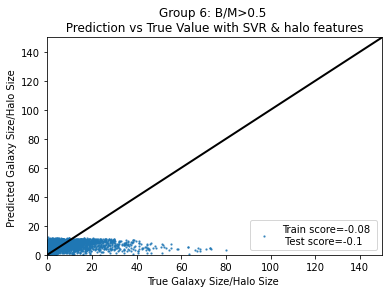

In [57]:
label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_6, 2),round(scores_SVR_6.mean(), 2) )
# label='Cross_val mean test score={}'.format(round(scores_RF.mean(),2))

plt.scatter(y_6, y_pred_SVR_6, s=7, marker='.', alpha=0.7, label=label)
plt.axis([0.0,150, 0.0,150])
plt.plot([0.0, 170], [0.0, 170], color = 'black', linewidth = 2)
plt.title('Group 6: B/M>0.5 \n Prediction vs True Value with SVR & halo features ')
plt.xlabel('True Galaxy Size/Halo Size ')
plt.ylabel(' Predicted Galaxy Size/Halo Size  ')
plt.legend(loc='lower right')
plt.savefig('Group6_Prediction_vs_True_SVR_halo_features_after_hyperparam_opt.jpeg', dpi=500)

plt.show()

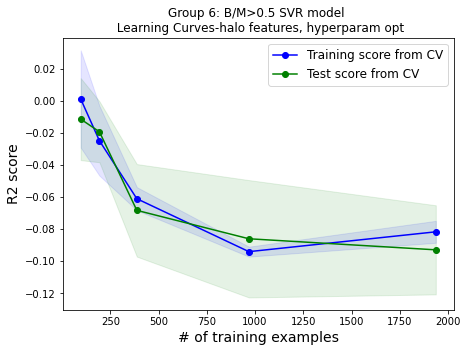

In [58]:
lc_6 = plot_learning_curve(best_SVR_6, 'Group 6: B/M>0.5 SVR model \n Learning Curves-halo features, hyperparam opt', X_imp_6, y_6, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
lc_6.savefig('LC_SVR_Group6_after_hyper_opt_w_halo_feat.jpeg', dpi=500)

### SVR Predicted vs True Galaxy Sizes - The figure with all the results of each morphology bin

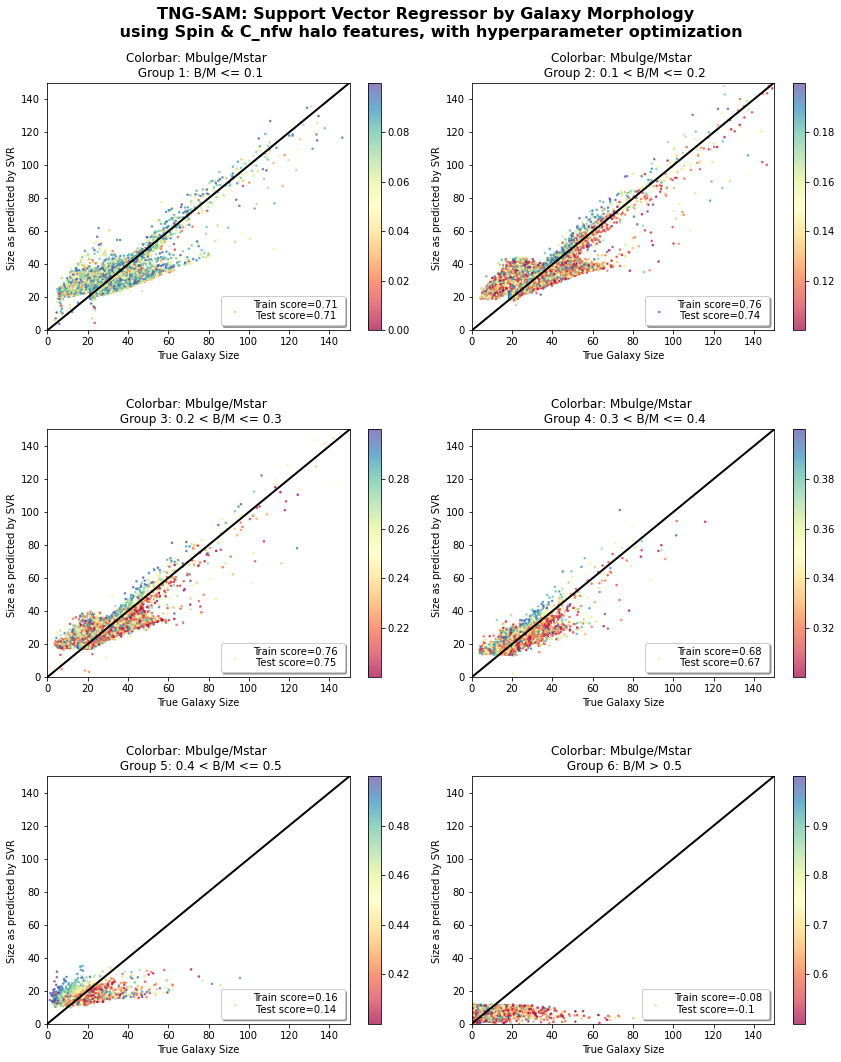

In [59]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Support Vector Regressor by Galaxy Morphology \n using Spin & C_nfw halo features, with hyperparameter optimization', fontsize=16, fontweight='bold')


label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_1, 2),round(scores_SVR_1.mean(), 2) )
fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_1,
            c = df_1.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=label) #,label= label, vmin=-2, vmax=1.0)
# ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
# ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_1, ax=ax1)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_2, 2),round(scores_SVR_2.mean(), 2) )
fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_2,
            c = df_2.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
# ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
# ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_2, ax=ax2)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_3, 2),round(scores_SVR_3.mean(), 2) )
fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_3,
            c = df_3.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
# ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_3, ax=ax3)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_4, 2),round(scores_SVR_4.mean(), 2) )
fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_4,
            c = df_4.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
# ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_4, ax=ax4)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_5, 2),round(scores_SVR_5.mean(), 2) )
fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_5,
            c = df_5.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
# ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_5, ax=ax5)

label = 'Train score={} \n Test score={}'.format(round(best_SVR_trainscore_6, 2),round(scores_SVR_6.mean(), 2) )
fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], y_pred_SVR_6,
            c = df_6.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label= label) #, vmin=-2, vmax=1.0)
# ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Colorbar: Mbulge/Mstar \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Size as predicted by SVR ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

# plt.savefig("TTNG-SAM_SVR_by_Galaxy_Morphology_w_hyperparam_opt_Spin_Cnfw_features.jpeg", dpi=500)
plt.show()

### SVR Learning Curves - The figure with all the morphology bins

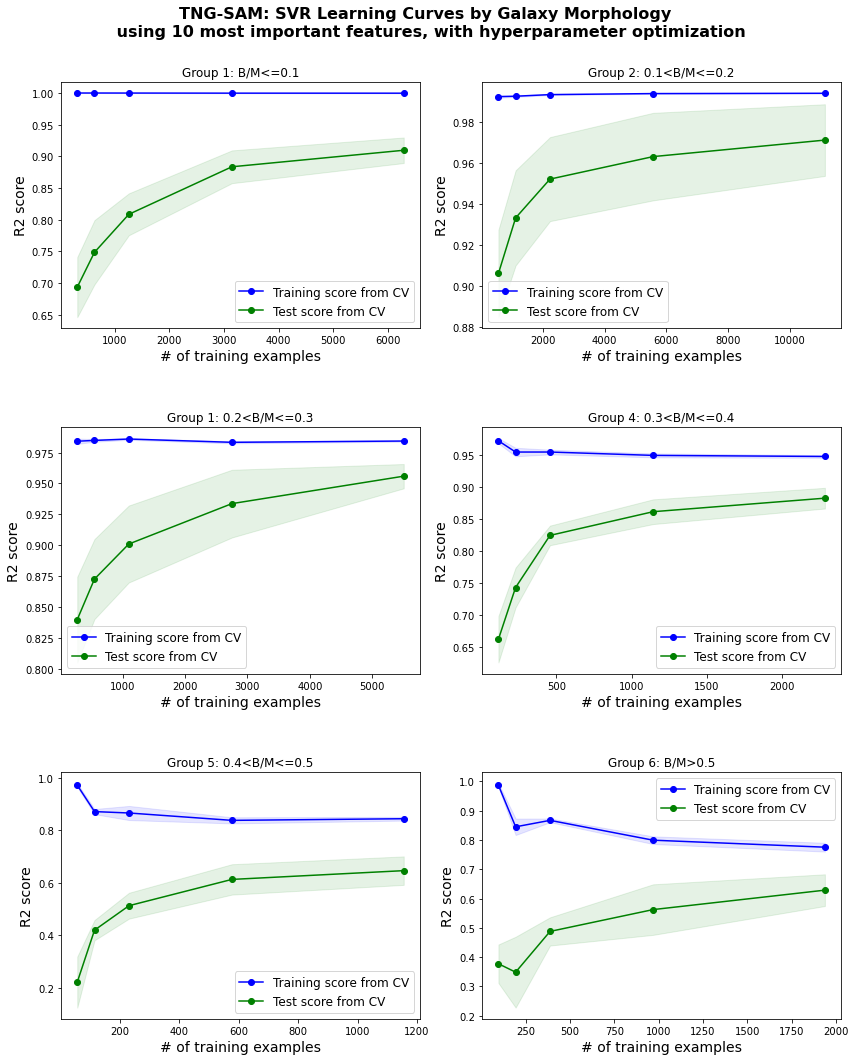

In [57]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import sklearn as sklearn

# def plot_learning_curve_for_6_galaxy_morphologies(estimator, title, X, y, ylim=None, cv=5,
#                         n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
#     """
#     Generate a simple plot of the test and training learning curve.

#     Parameters
#     ----------
#     estimator : object type that implements the "fit" and "predict" methods
#         An object of that type which is cloned for each validation.

#     title : string
#         Title for the chart.

#     X : array-like, shape (n_samples, n_features)
#         Training vector, where n_samples is the number of samples and
#         n_features is the number of features.

#     y : array-like, shape (n_samples) or (n_samples, n_features), optional
#         Target relative to X for classification or regression;
#         None for unsupervised learning.

#     ylim : tuple, shape (ymin, ymax), optional
#         Defines minimum and maximum yvalues plotted.

#     cv : int, cross-validation generator or an iterable, optional
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:
#           - None, to use the default 3-fold cross-validation,
#           - integer, to specify the number of folds.
#           - :term:`CV splitter`,
#           - An iterable yielding (train, test) splits as arrays of indices.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     n_jobs : int or None, optional (default=None)
#         Number of jobs to run in parallel.
#         ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
#         ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
#         for more details.

#     train_sizes : array-like, shape (n_ticks,), dtype float or int
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the dtype is float, it is regarded as a
#         fraction of the maximum size of the training set (that is determined
#         by the selected validation method), i.e. it has to be within (0, 1].
#         Otherwise it is interpreted as absolute sizes of the training sets.
#         Note that for classification the number of samples usually have to
#         be big enough to contain at least one sample from each class.
#         (default: np.linspace(0.1, 1.0, 5))
#     """

start_time = time.time()
lc_fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
lc_fig_all.suptitle('TNG-SAM: SVR Learning Curves by Galaxy Morphology \n using Spin & C_nfw features, with hyperparameter optimization', fontsize=16, fontweight='bold')

# Learning Curve Group 1
ax1.set_title('Group 1: B/M<=0.1')
ylim = None
if ylim is not None:
    ax1.set_ylim(*ylim)
ax1.set_xlabel("# of training examples",fontsize = 14)

ax1.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_1 = scaler.fit_transform(X_1)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_1, X_1, y_1, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax1.legend(loc="best",fontsize = 12)

# Learning Curve Group 2
ax2.set_title('Group 2: 0.1<B/M<=0.2')
ylim = None
if ylim is not None:
    ax2.set_ylim(*ylim)
ax2.set_xlabel("# of training examples",fontsize = 14)

ax2.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_2 = scaler.fit_transform(X_2)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_2, X_2, y_2, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax2.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax2.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax2.legend(loc="best",fontsize = 12)

# Learning Curve Group 3
ax3.set_title('Group 1: 0.2<B/M<=0.3')
ylim = None
if ylim is not None:
    ax3.set_ylim(*ylim)
ax3.set_xlabel("# of training examples",fontsize = 14)

ax3.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_3 = scaler.fit_transform(X_3)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_3, X_3, y_3, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax3.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax3.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax3.legend(loc="best",fontsize = 12)

# Learning Curve Group 4
ax4.set_title('Group 4: 0.3<B/M<=0.4')
ylim = None
if ylim is not None:
    ax4.set_ylim(*ylim)
ax4.set_xlabel("# of training examples",fontsize = 14)

ax4.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_4 = scaler.fit_transform(X_4)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_4, X_4, y_4, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax4.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax4.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax4.legend(loc="best",fontsize = 12)

# Learning Curve Group 5
ax5.set_title('Group 5: 0.4<B/M<=0.5')
ylim = None
if ylim is not None:
    ax5.set_ylim(*ylim)
ax5.set_xlabel("# of training examples",fontsize = 14)

ax5.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_5 = scaler.fit_transform(X_5)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_5, X_5, y_5, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax5.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax5.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax5.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax5.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax5.legend(loc="best",fontsize = 12)

# Learning Curve Group 6
ax6.set_title('Group 6: B/M>0.5')
ylim = None
if ylim is not None:
    ax6.set_ylim(*ylim)
ax6.set_xlabel("# of training examples",fontsize = 14)

ax6.set_ylabel("R2 score",fontsize = 14)

scale = False
if (scale == True):
    scaler = sklearn.preprocessing.StandardScaler()
    X_6 = scaler.fit_transform(X_6)
    
train_sizes, train_scores, test_scores = learning_curve(
    best_SVR_6, X_6, y_6, cv=KFold(n_splits=5, shuffle=True), n_jobs=-1, train_sizes=np.array([0.05,0.1,0.2,0.5,1.0]), scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

ax6.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="b")
ax6.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax6.plot(train_sizes, train_scores_mean, 'o-', color="b",
         label="Training score from CV")
ax6.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score from CV")

ax6.legend(loc="best",fontsize = 12)

lc_fig_all.tight_layout()
lc_fig_all.subplots_adjust(top=0.91, hspace=0.4) #, wspace=0.4)

plt.savefig("TNG-SAM_LearningCurves_SVR_by_Galaxy_Morphology_w_hyperparam_opt_Spin_Cnfw_features.jpeg", dpi=500)
plt.show()
elapsed_time = time.time() - start_time
print(f"Elapsed time to plot SVR learning curves for all morphologies: {elapsed_time:.3f} seconds")

